In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
%%writefile lp_sim_balan.py

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from LogSinkhornGPU import LogSinkhornTorch

def batch_iteration(pi, x, y, muref, nuref, eps, partition, device='cuda'):
    # Get maximum size of cell marginals
    B = len(partition)
    max_size = np.max(list(map(len, partition)))
    Mu = torch.zeros((B, max_size), device=device)
    Nu = torch.zeros((B, len(y)), device=device)
    Muref = torch.zeros((B, max_size), device=device)
    Nuref = torch.zeros((B, len(y)), device=device)
    C = torch.zeros((B, max_size, len(y)), device=device)
    # Batch problems
    for (i, J) in enumerate(partition):
        piJ = pi[J, :]
        xJ = x[J]
        muJ = torch.sum(piJ, dim=1).ravel()
        nuJ = torch.sum(piJ, dim=0).ravel()
        Mu[i, :len(J)] = muJ
        Nu[i, :] = nuJ
        # This might be different in the unbalanced case:
        Muref[i, :len(J)] = muref[0,J] 
        Nuref[i, :] = nuref[0,:]
        C[i, :len(J), :] = (xJ.reshape(-1,1) - y.reshape(1,-1))**2
    solver = LogSinkhornTorch(Mu, Nu, C, eps, muref=Muref, nuref=Nuref)

    solver.iterate_until_max_error()
    # Retrieve solution
    pi_batch = solver.get_pi_dense()
    pi_new = torch.zeros_like(pi)
    for (i, J) in enumerate(partition):
        pi_new[J,:] = pi_batch[i, :len(J), :]
    return pi_new

def main():
    device = 'cuda'
    M = N = 32
    muref = torch.ones(1, M, device=device)
    nuref = torch.ones(1, N, device=device)
    muref = muref/torch.sum(muref, dim=1, keepdim=True)
    nuref = nuref/torch.sum(nuref, dim=1, keepdim=True)
    x = torch.linspace(0, 1, M, device=device)
    y = torch.linspace(0, 1, N, device=device)

    # PARTITIONS
    partA = [[i, i+1] for i in range(0, N, 2)]
    partB = [[0], *[[i, i+1] for i in range(1, N-2, 2)], [N-1]]

    # INITIAL PLAN
    # pi = torch.ones((M, N), device=device) / (M*N) # prod initialization
    pi = torch.fliplr(torch.eye(M, device=device))/M

    # PARAMETERS
    eps = 1/M**2
    n_iter = 25

    cols = 5
    rows = (n_iter-1)//cols + 1
    fig, axs = plt.subplots(
        nrows=rows, ncols=cols, figsize=(2*cols, 2*rows),
        sharex=True, sharey=True,
    )

    for i, ax in tqdm(enumerate(axs.flatten())):
        partition = partA if i%2 == 0 else partB
        pi = batch_iteration(pi, x, y, muref, nuref, eps, partition)
        ax.imshow(pi.cpu().detach().T, origin="lower")

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

Writing lp_sim_balan.py


A has 16 cells:
 [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31]]
B has 17 cells:
 [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31]]


0it [00:00, ?it/s]

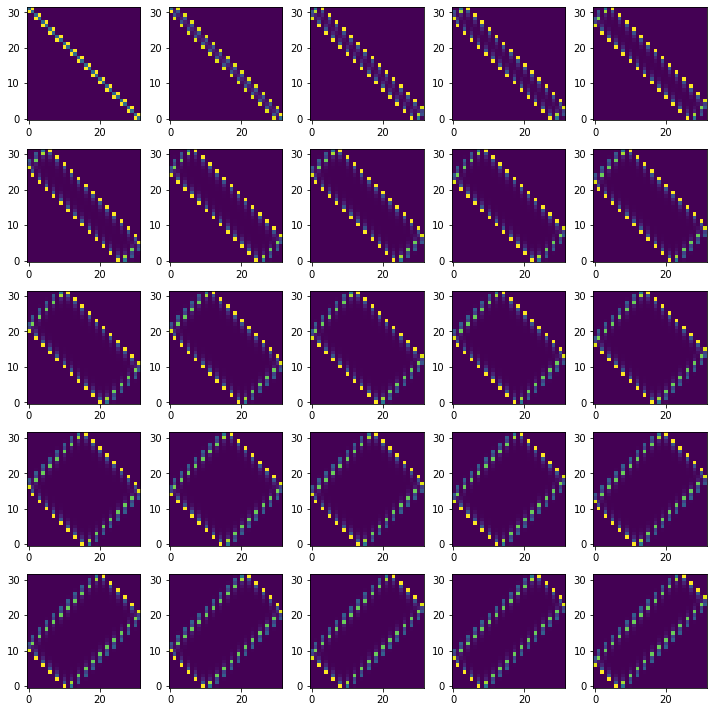


*** Profile printout saved to text file 'lprun_balan'. 


Timer unit: 1e-09 s

Total time: 10.4523 s
File: /usr/users/nguyen45/.local/lib/python3.8/site-packages/LogSinkhornGPU/Sinkhorn.py
Function: get_new_beta at line 261

Line #      Hits         Time  Per Hit   % Time  Line Contents
   261                                               def get_new_beta(self):
   262     81463  885956770.0  10875.6      8.5          return - self.eps * (
   263    162926 5711662478.0  35056.8     54.6              softmin_torch(
   264    162926 3160027741.0  19395.5     30.2                  (self.alpha[:, :, None] - self.C) / self.eps
   265     81463  653851938.0   8026.4      6.3                  + self.logmuref[:, :, None], dim=1
   266                                                       )
   267    162926   40794464.0    250.4      0.4              + self.lognuref - self.lognu
   268                                                   )

In [3]:
from lp_sim_balan import main
from LogSinkhornGPU import LogSinkhornTorch

%lprun -T lprun_balan -f LogSinkhornTorch.get_new_beta main()